# Visualization -EigenCam (in progress)
**Author**: Hyeri

In [47]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import Model, Input 
import cv2

def img_to_tensor(img_path, img_size=(100,100,3), RGB=True):
    img = cv2.imread(img_path, 1)[...,::-1]
    img_tensor = cv2.resize(img, img_size[:2])
    img_tensor = np.float32(img_tensor) / 255 if RGB else img_tensor
    return np.float32(img_tensor)

def get_mean_std(img_tensor):
    img_resized = img_tensor.reshape(img_size[2], -1).transpose()
    return img_resized.mean(axis=0), img_resized.std(axis=0)

def preprocessing_image(img_size, img_tensor, img_mean, img_std):
    prep_img_tensor = img_tensor.reshape(img_size[2], -1).transpose()
    prep_img_tensor -= img_mean
    prep_img_tensor /= img_std
    prep_img_tensor = prep_img_tensor.transpose().reshape(img_size)
    return np.float32(prep_img_tensor[np.newaxis, ...])

In [48]:
labels_raf = {  0:  'Anger',
                1:  'Disgust',
                2:  'Fear',
                3:  'Happiness',
                4:  'Neutral',
                5:  'Sadness',
                6:  'Surprise'
            }
labels_fer = {  0:  'NF',
                1:  'anger',
                2:  'comtempt',
                3:  'disgust',
                4:  'fear',
                5:  'happiness',
                6:  'neutral',
                7:  'sadness',
                8:  'surprise',
                9:  'unknown'
            }

## Path

In [49]:
model_fer = './models/model_ferplus_h.h5'
model_raf = './models/model_raf_h.h5'
input_model = model_raf

# 5, 6, 7, 10, 11, 13, 14, 16, 19, 22, 26
img_path = './data/RAF/images/test_0005_aligned.jpg'

## Image

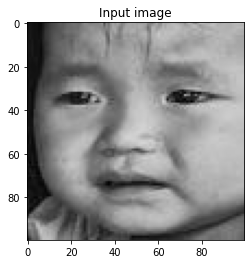

In [50]:
img_size = (100,100,3)
img_tensor = img_to_tensor(img_path, img_size)
plt.title('Input image')
plt.imshow(img_tensor)
img_mean, img_std = get_mean_std(img_tensor)
prep_img_tensor = preprocessing_image(img_size, copy.deepcopy(img_tensor), img_mean, img_std)

input_img_tensor = img_tensor[np.newaxis, ...]

## Model -RAF

In [51]:
# Emotion label for RAF-DB
emotions = {    0:  'Anger',
                1:  'Disgust',
                2:  'Fear',
                3:  'Happiness',
                4:  'Neutral',
                5:  'Sadness',
                6:  'Surprise'
            }

model = load_model(input_model)
#print([layer.name for layer in model.layers])

# Activation model : ~ last conv layer
last_conv_layer_name = 'conv2d_7'
last_conv_layer = model.get_layer(last_conv_layer_name)
activation_model = tf.keras.Model(model.inputs, last_conv_layer.output)

# Classifier model : last conv layer + 1 ~
classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in ['batch_normalization_7', 'max_pooling2d_2', 'global_average_pooling2d', 'dense', 'dropout', 'dense_1']:
    x = model.get_layer(layer_name)(x)
classifier_model = tf.keras.Model(classifier_input, x)

"""
conv_output = [layer.output for layer in model.layers[:-6]]
activation_model = Model(inputs =[model.input], outputs = conv_output)
activations_list = activation_model.predict(img_tensor)
len(activations_list)
print([i.shape for i in activations_list])
"""

In [52]:
classification_result = np.argmax(model.predict(input_img_tensor)[0])
activation = activation_model.predict(input_img_tensor)                   # shape (1, 11, 11, 128)
#print(activation.shape)

2022-01-24 01:35:05.747545: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-24 01:35:05.837051: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


## EigenCam

In [53]:
def get_class_activation_map(activation):
    reshaped_activation = activation.reshape(activation.shape[2], -1).transpose()
    reshaped_activation -= reshaped_activation.mean(axis=0)
    _, _, VT = np.linalg.svd(reshaped_activation, full_matrices=True)
    projection = reshaped_activation @ VT[0, :]
    projection = projection.reshape(activation.shape[:2])
    return np.float32(projection)

cam = get_class_activation_map(activation[0])

def scale_cam_image(img, target_size=(100,100)):
    img = img - np.min(img)
    img = img / (1e-7 + np.max(img))
    img = cv2.resize(img, target_size)
    result = np.float32(img)
    return result

def show_cam_on_image(img: np.ndarray, mask: np.ndarray, colormap: int = cv2.COLORMAP_JET) -> np.ndarray:
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), colormap)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = np.float32(heatmap) / 255
    if np.max(img) > 1:
        raise Exception(
            "The input image should np.float32 in the range [0, 1]")
    cam = 0.5 * heatmap + img
    cam /= np.max(cam)
    return np.uint8(255 * cam)

## Visualization

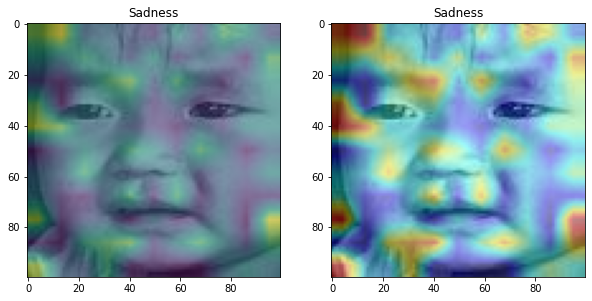

In [54]:
title = labels_raf[classification_result] if input_model==model_raf else labels_fer[classification_result]
_, axs = plt.subplots(1, 2, figsize=(10, 10))
cam_1 = scale_cam_image(cam, (100,100))
axs[0].set_title(title)
axs[0].imshow(img_tensor)
axs[0].imshow(cam_1, alpha=0.5)

cam_2 = show_cam_on_image(img_tensor, scale_cam_image(cam))
plt.title(title)
axs[1].imshow(cam_2)

plt.show()